# Day 2

Today, we will continue with our exploratory analysis in R. To start, we will look at how to plot and summarize univariate and bivariate relationships in the data and create summary tables. Second, we will get a glimpse of the tidyverse package, which is a collection of data science packages. 

In this chapter, we will use a sample of the National Health and Nutrition Examination Survey ([NHANES](https://www.cdc.gov/nchs/nhanes/index.htm)) containing lead, blood pressure, BMI, smoking status, alcohol use, and demographic variables from NHANES 1999-2018. There are 31,625 observations in this sample. Use the help operator `?NHANESsample` to read the variable descriptions.

In [1]:
suppressPackageStartupMessages(library(GGally)) # used for pairwise plots
suppressPackageStartupMessages(library(gt)) # used for summary tables
suppressPackageStartupMessages(library(gtsummary)) # used for summary tables
suppressPackageStartupMessages(library(tidyverse)) # collection of data science tools
suppressPackageStartupMessages(library(HDSinRdata)) # data source
data(NHANESsample)

In [2]:
data(NHANESsample)
dim(NHANESsample)
names(NHANESsample)

[1] 31265    21

[1] "ID"            "AGE"           "SEX"           "RACE"         
 [5] "EDUCATION"     "INCOME"        "SMOKE"         "YEAR"         
 [9] "LEAD"          "BMI_CAT"       "LEAD_QUANTILE" "HYP"          
[13] "ALC"           "DBP1"          "DBP2"          "DBP3"         
[17] "DBP4"          "SBP1"          "SBP2"          "SBP3"         
[21] "SBP4"

## Univariate Relationships

To start our exploration, we will look at whether there are any missing values. We use the `complete.cases()` function to observe that there are no complete cases. We also see that the subsequent blood pressure measurements and alcohol use have the highest percentage of missing values. For demonstration, we choose to only keep the first systolic an diastolic blood pressure measurements and do a complete case analysis using the `na.omit()` function to define our complete data frame `nhanes_df`. 

In [3]:
sum(complete.cases(NHANESsample))
apply(NHANESsample, 2, function(x) sum(is.na(x)))/nrow(NHANESsample)

[1] 0

ID           AGE           SEX          RACE     EDUCATION 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0006716776 
       INCOME         SMOKE          YEAR          LEAD       BMI_CAT 
 0.0000000000  0.0000000000  0.0000000000  0.0000000000  0.0000000000 
LEAD_QUANTILE           HYP           ALC          DBP1          DBP2 
 0.0000000000  0.0000000000  0.0268671038  0.0600351831  0.0639053254 
         DBP3          DBP4          SBP1          SBP2          SBP3 
 0.0709739325  0.8911242604  0.0600351831  0.0639053254  0.0709419479 
         SBP4 
 0.8911242604

In [4]:
nhanes_df <- na.omit(subset(NHANESsample, select= -c(SBP2, SBP3, SBP4, DBP2, DBP3, DBP4)))

In the last chapter, we introduced the `table()` and `summary()` functions to quickly summarize categorical and quantitative vectors. 

In [5]:
table(nhanes_df$SMOKE)
summary(nhanes_df$YEAR)


NeverSmoke  QuitSmoke StillSmoke 
     13774       8019       6799 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1999    2003    2007    2008    2011    2017 

We decide to select the most recent observations from NHANES 2017-2018 for our analysis in this chapter. We use the `subset()` function to select these rows. 

In [6]:
nhanes_df <- subset(nhanes_df, nhanes_df$YEAR==2017)

As shown above, smoking status has been coded into three categories: "NeverSmoke", "QuitSmoke", and "StillSmoke". We want to create a new variable to represent whether someone has ever smoked. To do so, we use the `ifelse()` function, which allows us to create a new vector using logic. The logic captured by this function is that we will take one value if we meet some condition(s) and we will take a second value otherwise. The first argument is a vector of TRUE/FALSE values representing the conditions, the next argument is the value to use if we meet the condition(s), and the last argument is the value to use otherwise. We use this function to create a new vector `EVER_SMOKE` that is equal to "Yes" for those who are either still smoking or quit smoking and equal to "No" otherwise. 

In [7]:
nhanes_df$EVER_SMOKE <- ifelse(nhanes_df$SMOKE %in% c("QuitSmoke", "StillSmoke"), "Yes", "No")
table(nhanes_df$EVER_SMOKE)


  No  Yes 
1411 1173 

The `summary()` and `table()` functions allow us to summarize the univariate sample distributions of columns. We may also want to plot these distributions. We saw yesterday that the `hist()` function creates a histogram plot. Below we use this function to plot a histogram of the log transformation of the lead column.

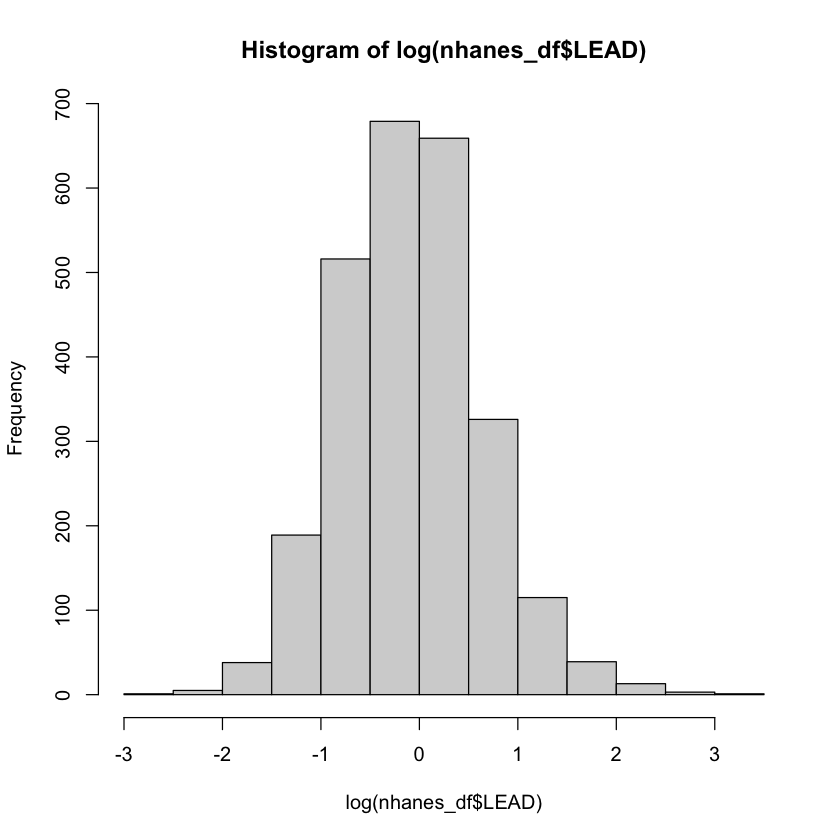

In [8]:
hist(log(nhanes_df$LEAD))

If we want to polish this figure, we can use some of the other optional arguments to the `hist()` function.  For example, we may want to update the text `log(nhanes_df$lead)` in the title and x-axis. Below, we update the [color](http://www.stat.columbia.edu/~tzheng/files/Rcolor.pdf), labels, and number of bins for the plot. The argument `breaks` specifies the number of bins to use to create the histogram, `col` specifies the color, `main` specifies the title of the plot, and `xlab` specifies the x-axis label (using `ylab` would specify the y-axis label). Read the documentation `?hist` for the full list of arguments available.

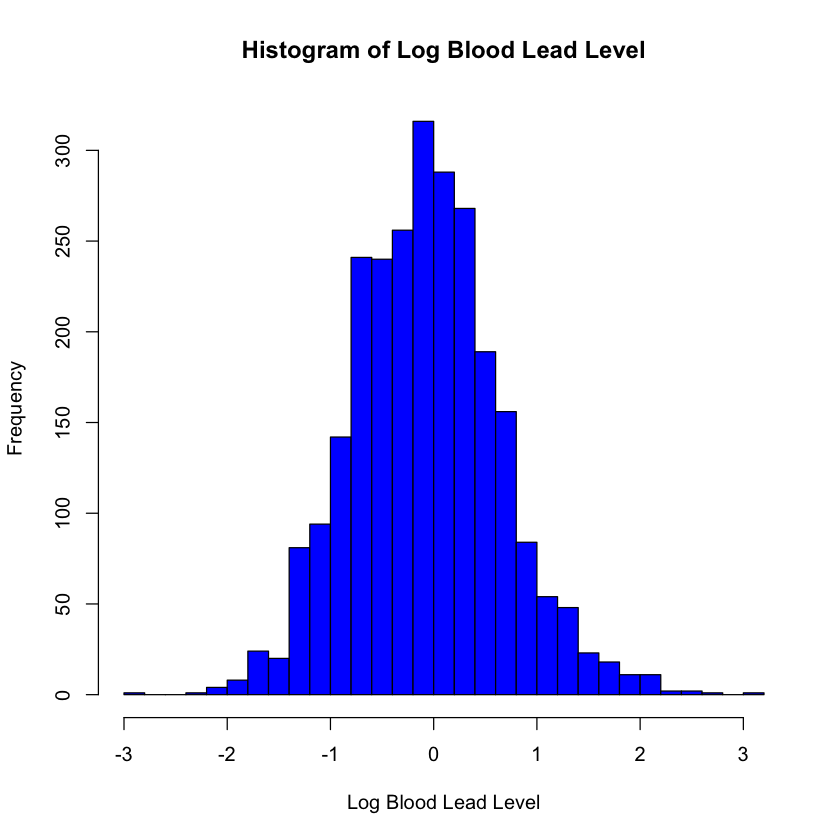

In [9]:
hist(log(nhanes_df$LEAD), breaks = 30, col="blue", main="Histogram of Log Blood Lead Level",
    xlab="Log Blood Lead Level")

For categorical variables, we may want to plot the counts in each category using a bar plot. The function `barplot()` asks us to specify the `names` and `heights` of the bars. To do so, we will need to store the counts for each category. Again, we update the color and labels.

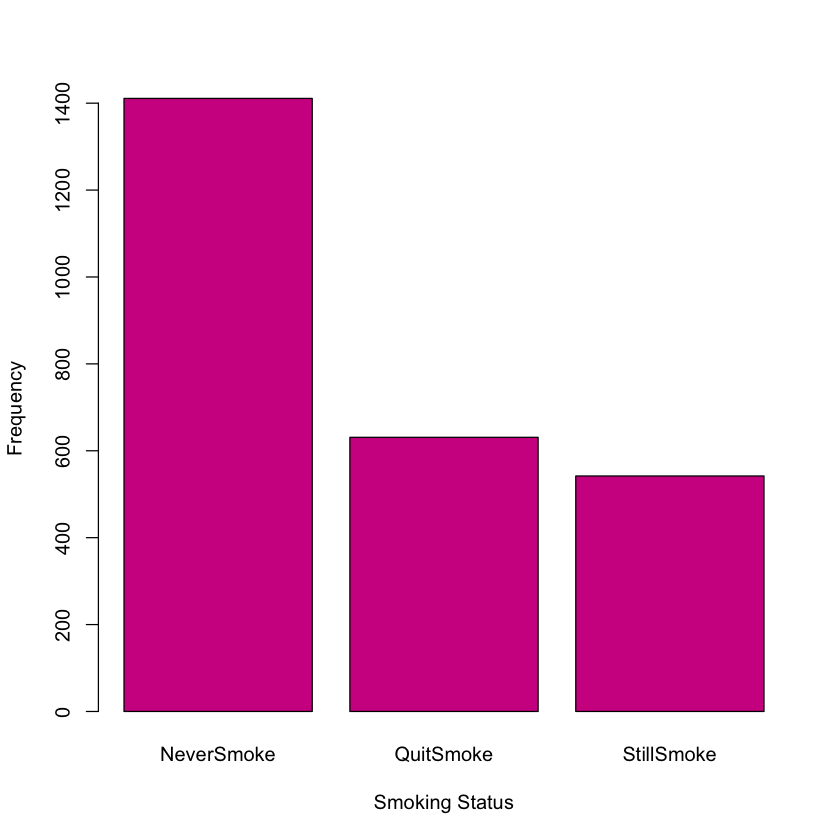

In [10]:
smoke_counts <- table(nhanes_df$SMOKE)
barplot(height=smoke_counts, names=names(smoke_counts), col="violetred",
       xlab="Smoking Status", ylab="Frequency")

With a bar plot, we can even specify a different color for each bar. To do so, `col` must be a vector of specified colors with the same length as the number of categories.

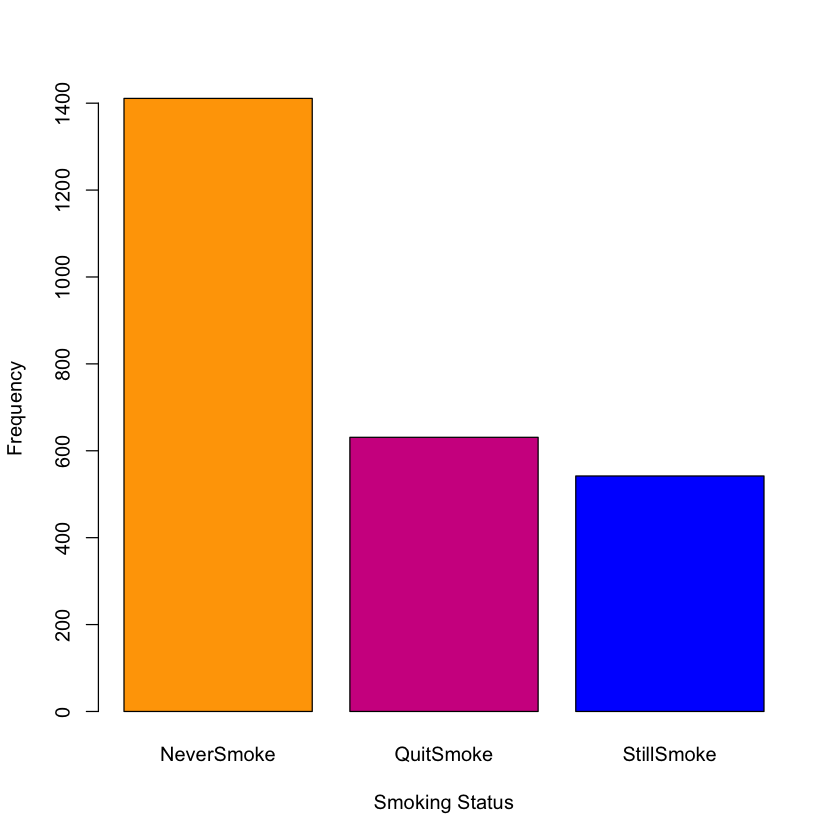

In [11]:
barplot(height=smoke_counts, names=names(smoke_counts), col=c("orange","violetred","blue"),
       xlab="Smoking Status", ylab="Frequency")

## Bivariate Distributions

We now turn our attention to relationships among multiple columns. When we have two categorical variables, we can use the `table()` function to find the counts across all combinations. For example, below we look at the distribution of smoking status levels by sex. We observe that a higher percentage of female participants have never smoked.

In [12]:
table(nhanes_df$SMOKE, nhanes_df$SEX)

            
             Male Female
  NeverSmoke  596    815
  QuitSmoke   390    241
  StillSmoke  324    218

To look at the sample distribution of a continuous variable stratified by a cateogrical variable, we could call the `summary()` function for each subset of the data. Below we look at the distribution of blood lead level by sex. 

In [13]:
summary(nhanes_df$LEAD[nhanes_df$SEX=="Female"])
summary(nhanes_df$LEAD[nhanes_df$SEX=="Male"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.100   0.470   0.770   0.977   1.208   8.670 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.050   0.700   1.090   1.461   1.660  22.010 

We could also observe this visually through a box plot. When given one categorical variable and one continuous variable, the `plot()` function creates a box plot. By default, the first argument is the x-axis variable and second argument is the y-axis variable. 

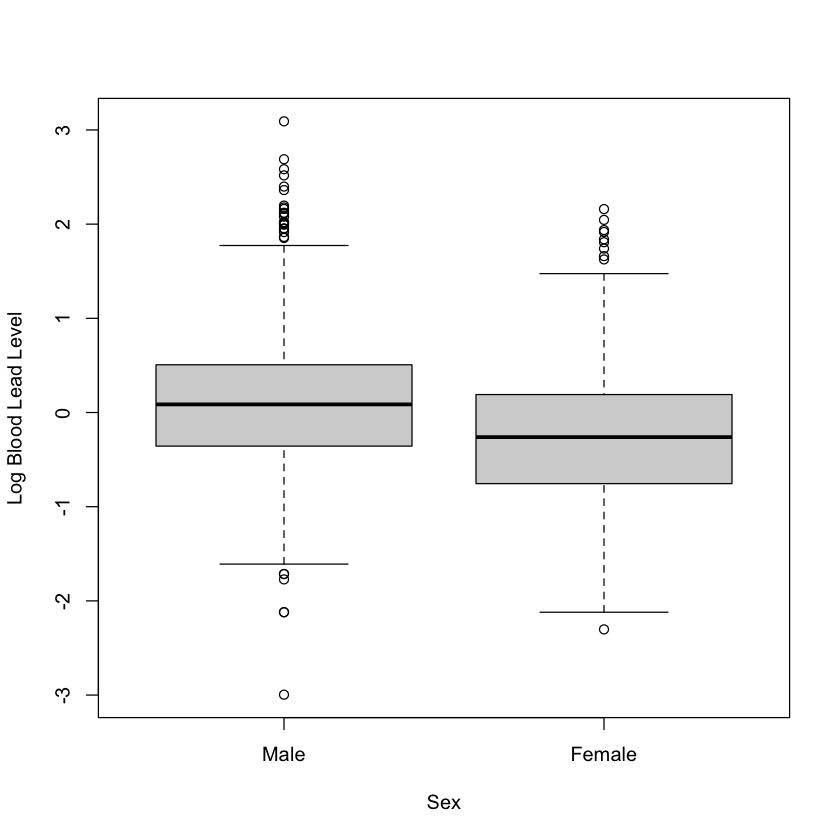

In [14]:
plot(nhanes_df$SEX, log(nhanes_df$LEAD), ylab="Log Blood Lead Level", xlab="Sex")

Alternatively, we could use the `boxplot()` function, which can be passed a formula. A formula is a string representation of how to group the data, where the left hand side is the continuous variable and the right hand side is one or more categorical variables to group by. In the case below, we group by multiple columns, `SEX` and `EVER_SMOKE`, so our formula is `log(LEAD)~SEX+EVER_SMOKE`. The second argument to the function specifies the data.  We specify the column colors to show the link between the box plots shown. 

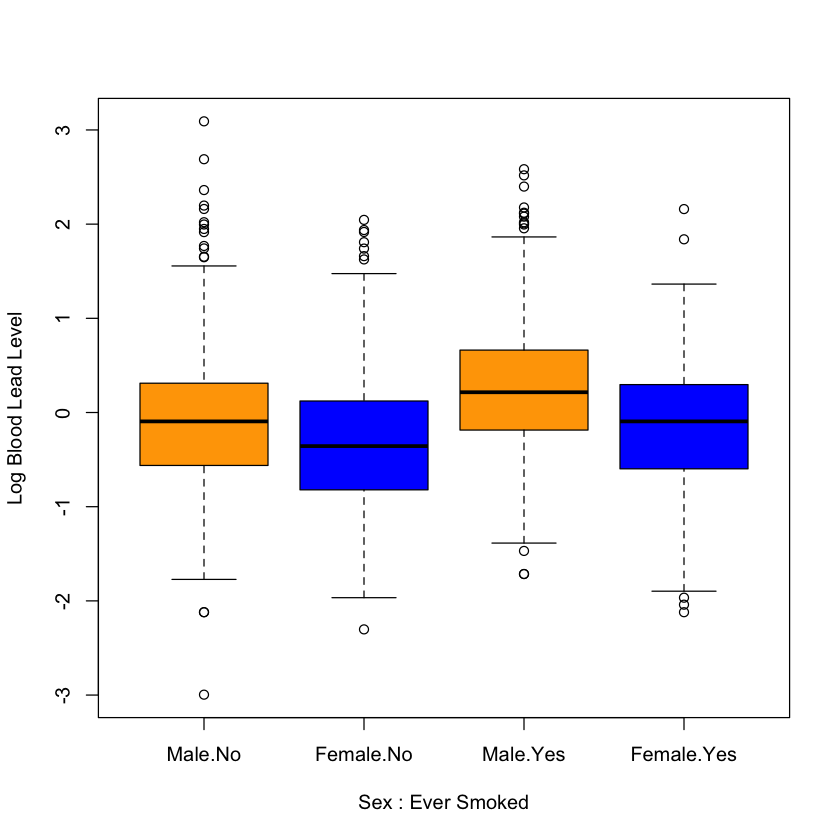

In [15]:
boxplot(log(LEAD)~SEX+EVER_SMOKE, data=nhanes_df, col=c("orange", "blue", "orange", "blue"),
       xlab="Sex : Ever Smoked", ylab = "Log Blood Lead Level")

To visualize the bivariate distributions between two continuous variables, we can use scatter plots. To create a scatter plot, we use the `plot()` function again. Below, we use this function to show the relationship between systolic and diastolic blood pressure. 

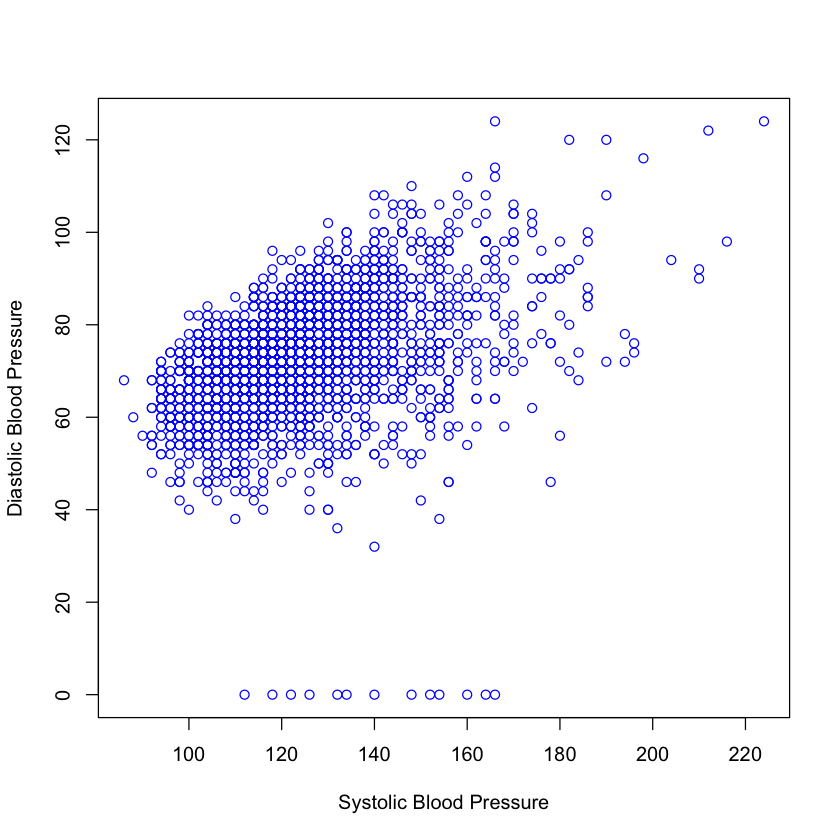

In [16]:
plot(nhanes_df$SBP1, nhanes_df$DBP1, col="blue", xlab="Systolic Blood Pressure",
    ylab="Diastolic Blood Pressure")

The two measures of blood pressure look highly correlated. We can calculate their Pearson and Spearman correlation using the `cor()` function. The default method is the Pearson correlation, but we can also calculate the Kendall or Spearman correlation by specifying the method. 

In [17]:
cor(nhanes_df$SBP1, nhanes_df$DBP1)
cor(nhanes_df$SBP1, nhanes_df$DBP1, method="spearman")

[1] 0.4166796

[1] 0.4711908

We may also want to add some extra information to our plot above. This time, instead of specifying the color manually, we use the column `hyp`, an indicator for hypertension, to specify the color. We have to make sure this vector is a factor for R to color by group. Additionally, we add a blue vertical and horizontal line using the `abline()` function to mark cutoffs for hypertension. Even though this function is called after `plot()`, the lines are automatically added to the current plot.

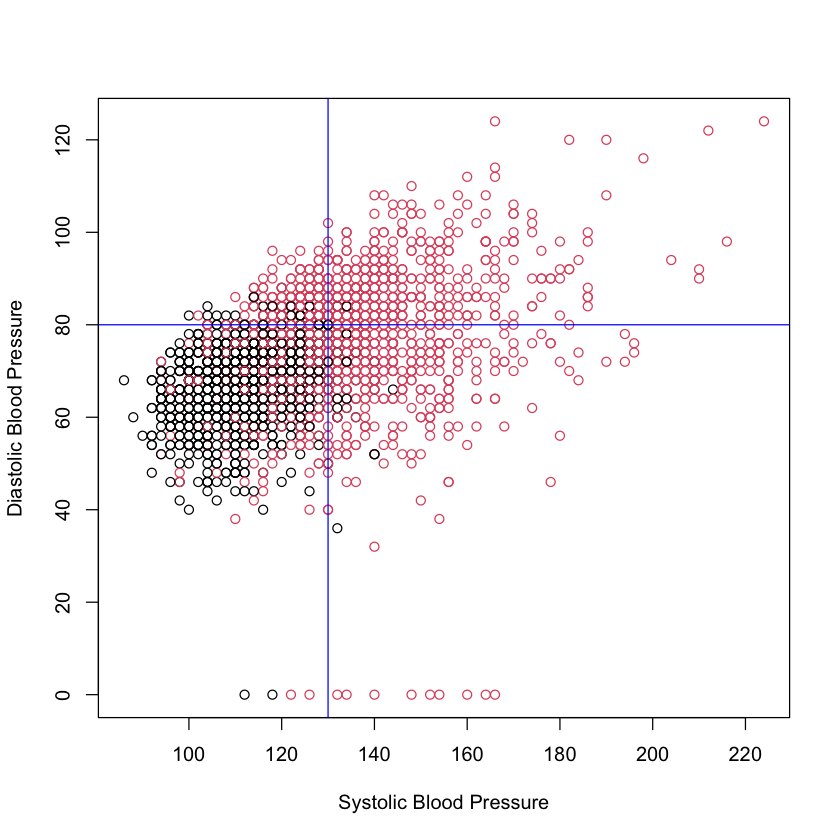

In [18]:
plot(nhanes_df$SBP1, nhanes_df$DBP1, col=as.factor(nhanes_df$HYP), 
     xlab="Systolic Blood Pressure",
     ylab="Diastolic Blood Pressure")
abline(v=130, col="blue")
abline(h=80, col="blue")

The plots above are all displayed as a single figure. If we want to display multiple plots next to each other, we can specify the graphical parameters using the `par()` function by updating the argument `mfrow=c(nrow, ncol)` with the number of columns and rows we would like to use for our figures. Below, we use this to display the distribution of log blood lead level between those with and without hypertension next to the plot from above. 

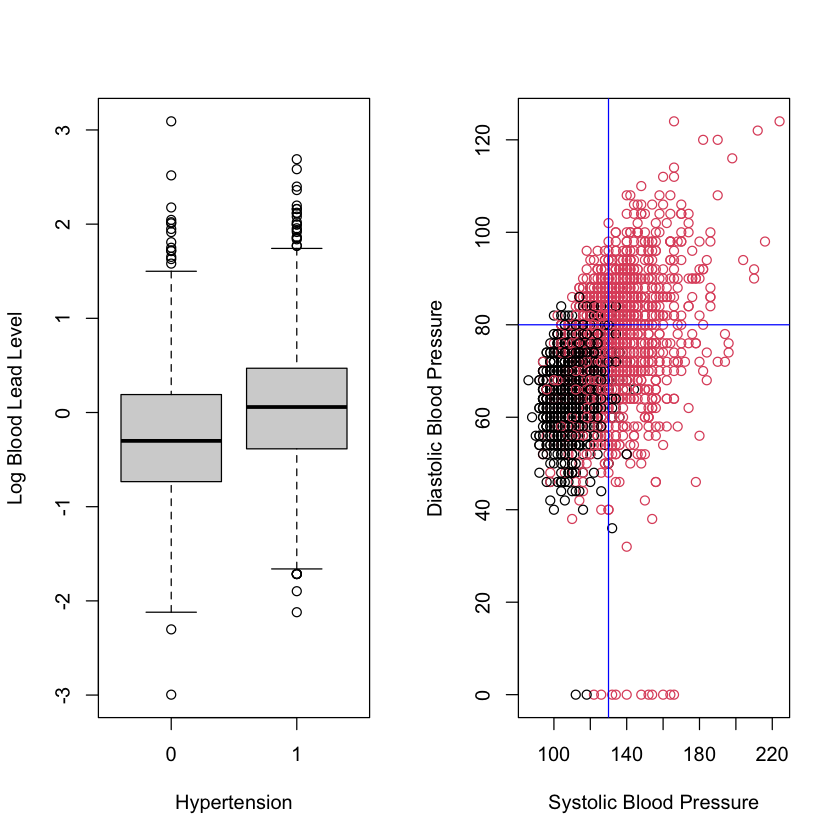

In [19]:
par(mfrow=c(1,2))

# boxplot
boxplot(log(LEAD)~HYP, data=nhanes_df, xlab="Hypertension", ylab="Log Blood Lead Level")

# scatterplot
plot(nhanes_df$SBP1, nhanes_df$DBP1, col=as.factor(nhanes_df$HYP), 
     xlab="Systolic Blood Pressure",
     ylab="Diastolic Blood Pressure")
abline(v=130, col="blue")
abline(h=80, col="blue")

We then reset to only display a single plot for future images using the `par()` function again.

In [20]:
par(mfrow=c(1,1))

## Tables

Another useful way to display information about your data is through tables. For example, it is standard practice in articles to have the first table in the paper give information about the study sample, such as the mean and standard deviation for all continuous variables and the proportions for categorical variables. The `gt` package is designed to create polished tables that can include footnotes, titles, column labels, etc. The `gtsummary` package is an extension of this package that can create summary tables. 

To start, we create a gt object (a special type of table) of the first six rows of our data using the `gt()` function. In R Markdown, the table would be displayed nicely. Since we are using this within a Jupyter notebook, however, we need to pass this to another function to make sure it displays correctly as HTML. The pipe operator `%>%` passes the result on the left hand side as the first argument to the function on the right hand side. You can see the difference in the formatting as opposed to printing the data.

In [21]:
gt(head(nhanes_df)) %>% gt:::as.tags.gt_tbl()

ID,AGE,SEX,RACE,EDUCATION,INCOME,SMOKE,YEAR,LEAD,BMI_CAT,LEAD_QUANTILE,HYP,ALC,DBP1,SBP1,EVER_SMOKE
93711,56,Male,Other Race,MoreThanHS,5.00,NeverSmoke,2017,2.15,BMI<=25,Q3,0,Yes,68,108,No
93713,67,Male,Non-Hispanic White,HS,2.65,StillSmoke,2017,3.71,BMI<=25,Q4,0,Yes,70,104,Yes
93716,61,Male,Other Race,MoreThanHS,5.00,QuitSmoke,2017,1.99,BMI>=30,Q3,0,Yes,72,120,Yes
93717,22,Male,Non-Hispanic White,HS,1.49,StillSmoke,2017,1.93,BMI<=25,Q3,0,Yes,62,116,Yes
93721,60,Female,Mexican American,LessThanHS,3.04,NeverSmoke,2017,0.75,BMI>=30,Q1,1,Yes,68,132,No
93722,60,Female,Non-Hispanic White,MoreThanHS,2.07,NeverSmoke,2017,0.98,BMI<=25,Q2,0,Yes,68,116,No


We will now show you how to use the `tbl_summary()` function in the `gtsummary` package. The first argument to this function is again the data frame. By default, this function will summarize all the variables in the data. Instead, we use the `include` argument to specify a list of variables to include. We then pipe this result to `as_gt()` which creates a gt table from the summary output before passing this output to the last function again to display the HTML table. Note that the table computes the total number of observations and the proportions for categorical variables and the median and interquartile range for continuous variables.

In [22]:
tbl_summary(nhanes_df, include= c("SEX", "RACE", "AGE", "EDUCATION", "SMOKE",
                                  "BMI_CAT", "LEAD", "SBP1", "DBP1", "HYP")) %>% 
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

We can update our table by changing some of its arguments. This time, we specify that we want to stratify our table by hypertension status so that the table summarizes the data by this grouping. Additionally, we change how continuous variables are summarized by specifying that we want to report the mean and standard deviation instead of the median and interquartile range. We do this using the `statistic` argument. The documentation for the `tbl_summary()` function can help you format this argument depending on which statistics you would like to display.

In [23]:
tbl_summary(nhanes_df, include= c("SEX", "RACE", "AGE", "EDUCATION", "SMOKE",
                                  "BMI_CAT", "LEAD", "SBP1", "DBP1", "HYP"),
           by = "HYP", statistic = list(all_continuous() ~ "{mean} ({sd})")) %>% 
  as_gt() %>% 
  gt:::as.tags.gt_tbl()

Shiny tags cannot be represented in plain text (need html)

## Intro to the tidyverse

We have seen how to select and filter data using row and column indices as well as using the `subset()` function. The `dplyr` package has its own functions that are useful to subset the data. The `select()` function allows us to select a subset of columns: this function takes in the data frame (or tibble) and the names or indices of the columns we want to select. For example, if we only wanted to select the variables for race and blood lead level, we could specify these two columns. To display the result of this selection, we use the pipe operator `%>%`. Recall that this takes the result on the left hand side and passes it as the first argument to the function on the right hand side. The output below shows that there are only two columns in the filtered data.  

In [24]:
select(nhanes_df, c(RACE, LEAD)) %>% head()

,RACE,LEAD
,<fct>,<dbl>
27663,Other Race,2.15
27664,Non-Hispanic White,3.71
27667,Other Race,1.99
27668,Non-Hispanic White,1.93
27670,Mexican American,0.75
27671,Non-Hispanic White,0.98


The `select()` function can also be used to *remove* columns by adding a negative sign in front of the vector of column names in its arguments. For example, below we keep all columns except `ID` and `LEAD_QUANTILE`. Note that in this case we have saved the selected data back to our data frame `nhanes_df`. Additionally, this time we used a pipe operator to pipe the data to the select function itself.

In [25]:
nhanes_df <- nhanes_df %>% select(-c(ID, LEAD_QUANTILE))
names(nhanes_df)

[1] "AGE"        "SEX"        "RACE"       "EDUCATION"  "INCOME"    
 [6] "SMOKE"      "YEAR"       "LEAD"       "BMI_CAT"    "HYP"       
[11] "ALC"        "DBP1"       "SBP1"       "EVER_SMOKE"

While `select()` allows us to choose a subset of columns, the `filter()` function allows us to choose a subset of rows.  The `filter()` function takes a data frame as the first argument and a vector of booleans as the second argument. This vector of booleans can be generated using conditional statements as we used in [Chapter 4](https://alicepaul.github.io/r-for-health-data-science/book/4_exploratory_analysis.html). Below, we choose to filter the data to only observations after 2008.

In [26]:
nhanes_df_recent <- nhanes_df %>% filter(YEAR >= 2008)

We can combine conditions by using multiple `filter` calls, by creating a more complicated conditional statement using the `&` (and), `|` (or), and `%in%` (in) operators, or by separating the conditions with commas within filter. Below, we demonstrate these three ways to filter the data to males between 2008 and 2012. Note that the `between()` function allows us to capture the logic `YEAR >= 2008 & YEAR <= 2012`. 

In [27]:
# Example 1: multiple filter calls
nhanes_df_males1 <- nhanes_df %>%
  filter(YEAR <= 2012) %>%
  filter(YEAR >= 2008) %>%
  filter(SEX == "Male")

# Example 2: combine with & operator
nhanes_df_males2 <- nhanes_df %>%
  filter((YEAR <= 2012) & (YEAR >= 2008) & (SEX == "Male"))

# Example 3: combine into one filter call with commas
nhanes_df_males3 <- nhanes_df %>%
  filter(between(YEAR, 2008, 2012), SEX == "Male")

The use of parentheses in the code above is especially important in order to capture our desired logic. In all these examples, we broke our code up into multiple lines, which makes it easier to read. A good rule of thumb is to not go past 80 characters in a line, and R Studio conveniently has a vertical gray line at this limit. To create a new line, you can hit enter either after an operator (e.g. `%>%`, `+`, `|`) or within a set of unfinished brackets or parentheses. Either of these breaks lets R know that your code is not finished yet. 

## Updating Rows and Columns using `rename`, `mutate`, and `arrange`

The next few functions we will look at will allow us to update the rows and columns in our data. For example, the `rename()` function allows us to change the names of columns. Below, we change the name of `INCOME` to `PIR` since this variable is the poverty income ratio and also update the name of `SMOKE` to be `SMOKE_STATUS`. When specifying these names, the new name is on the left of the `=` and the old name is on the right.

In [28]:
nhanes_df <- nhanes_df %>% rename(PIR = INCOME, SMOKE_STATUS = SMOKE)
names(nhanes_df)

[1] "AGE"          "SEX"          "RACE"         "EDUCATION"    "PIR"         
 [6] "SMOKE_STATUS" "YEAR"         "LEAD"         "BMI_CAT"      "HYP"         
[11] "ALC"          "DBP1"         "SBP1"         "EVER_SMOKE"

In the last chapter, we created a new variable called `EVER_SMOKE` based on the smoking status variable using the `ifelse()` function. Recall that this function allows us to specify a condition and then two alternative values based on whether we meet or do not meet this condition. We see that there are about 15,000 subjects in our data who never smoked. 

In [29]:
ifelse(nhanes_df$SMOKE_STATUS == "NeverSmoke", "No", "Yes") %>% table()

.
  No  Yes 
1411 1173 

Another useful function from the tidyverse is the `case_when()` function, which is an extension of the `ifelse()` function but allows to specify more than two cases. We demonstrate this function below to show how we could relabel the levels of the `SMOKE_STATUS` column. For each condition, we use the right side of the `~` to specify the value associated with a TRUE for that condition. 

In [30]:
case_when(nhanes_df$SMOKE_STATUS == "NeverSmoke" ~ "Never Smoked",
          nhanes_df$SMOKE_STATUS == "QuitSmoke" ~ "Quit Smoking",
          nhanes_df$SMOKE_STATUS == "StillSmoke" ~ "Current Smoker") %>% table()

.
Current Smoker   Never Smoked   Quit Smoking 
           542           1411            631 

Above, we did not store the columns we created. To do so, we could use the `$` operator or the  `cbind()` function. The tidyverse also includes an alternative function to add columns called `mutate()`. This function takes in a data frame and a set of columns with associated names to add to the data or update. In the example below, we create the column `EVER_SMOKE` and update the column `SMOKE_STATUS`. Within the `mutate()` function, we do not have to use the `$` operator to reference the column `SMOKE_STATUS`. Instead, we can specify just the column name and it will interpret it as that column.

In [31]:
nhanes_df <- nhanes_df %>% 
  mutate(EVER_SMOKE = ifelse(SMOKE_STATUS == "NeverSmoke", "No", "Yes"), 
         SMOKE_STATUS = case_when(SMOKE_STATUS == "NeverSmoke" ~ "Never Smoked",
                                  SMOKE_STATUS == "QuitSmoke" ~ "Quit Smoking",
                                  SMOKE_STATUS == "StillSmoke" ~ "Current Smoker")) 

The last function we will demonstrate in this section is the `arrange()` function, which takes in a data frame and a vector of columns used to sort the data (data is sorted by the first column with ties being sorted by the second column, etc.). By default, the `arrange()` function sorts the data in increasing order, but we can use the `desc()` function to instead sort in descending order. For example, the code below filters the data to male smokers before sorting by decreasing systolic and diastolic blood pressure in descending order. 

In [32]:
nhanes_df %>% 
  select(c(YEAR, SEX, SMOKE_STATUS, SBP1, DBP1, LEAD)) %>%
  filter(SEX == "Male", SMOKE_STATUS == "Current Smoker") %>%
  arrange(desc(SBP1), desc(DBP1)) %>%
  head(10)

,YEAR,SEX,SMOKE_STATUS,SBP1,DBP1,LEAD
,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
1,2017,Male,Current Smoker,212,122,2.20
2,2017,Male,Current Smoker,198,116,4.83
3,2017,Male,Current Smoker,186,88,1.67
4,2017,Male,Current Smoker,184,74,2.06
5,2017,Male,Current Smoker,182,92,3.19
6,2017,Male,Current Smoker,176,90,3.37
7,2017,Male,Current Smoker,174,102,1.23
8,2017,Male,Current Smoker,174,76,2.01
9,2017,Male,Current Smoker,170,98,0.95


## Summarizing using `summarize` and `group_by`

If we wanted to understand how many observations there are for each given race category, we could use the `table()` function as we described in earlier chapters. Another similar function is the `count()` function. This function takes in a data frame and one or more columns and counts the number of rows for each combination of unique values in these columns. If no columns are specified, it counts the total number of rows in the data frame. Below, we find the total number of rows (31,265) and the number of observations by race and year. We can see that the number in each group fluctuates quite a bit!

In [33]:
count(nhanes_df)
count(nhanes_df, RACE, YEAR)

n
<int>
2584


RACE,YEAR,n
<fct>,<dbl>,<int>
Mexican American,2017,358
Other Hispanic,2017,225
Non-Hispanic White,2017,992
Non-Hispanic Black,2017,568
Other Race,2017,441


Finding the counts like we did above is a form of a summary statistic for our data. The `summarize()` function in the tidyverse is used to compute summary statistics of the data and allows us to compute multiple statistics: this function takes in a data frame and one or more summary functions based on the given column names. In the example below, we find the total number of observations as well as the mean and median systolic blood pressure for Non-Hispanic Blacks. Note that the `n()` function is the function within `summarize()` that finds the number of observations. In the `mean()` and `median()` functions we set `na.rm=TRUE` to remove NAs before computing these values (otherwise we could get NA as our output).

In [34]:
nhanes_df %>%
  filter(RACE == "Non-Hispanic Black") %>%
  summarize(TOT = n(), MEAN_SBP = mean(SBP1, na.rm=TRUE), MEAN_DBP = mean(DBP1, na.rm=TRUE))

TOT,MEAN_SBP,MEAN_DBP
<int>,<dbl>,<dbl>
568,129.3451,74.27817


If we wanted to repeat this for the other race groups, we would have to change the arguments to the `filter()` function each time. To avoid having to repeat our code and/or do this multiple times, we can use the `group_by()` function, which takes a data frame and one or more columns with which to group the data by. Below, we group using the `RACE` variable. When we look at printed output it looks almost the same as it did before except we can see that its class is now a grouped data frame, which is printed at the top. In fact, a grouped data frame (or grouped tibble) acts like a set of data frames: one for each group. 

Grouping data is very helpful in combination with the `summarize()` function. Like with the `slice()` function, `summarize()` will calculate the summary values for each group. We can now find the total number of observations as well as the mean systolic and diastolic blood pressure values for each racial group. Note that the returned summarized data is in a tibble. 

In [35]:
nhanes_df %>% 
  group_by(RACE) %>%
  summarize(TOT = n(), MEAN_SBP = mean(SBP1, na.rm=TRUE), MEAN_DBP = mean(DBP1, na.rm=TRUE))

RACE,TOT,MEAN_SBP,MEAN_DBP
<fct>,<int>,<dbl>,<dbl>
Mexican American,358,123.5196,72.73743
Other Hispanic,225,123.8578,73.01333
Non-Hispanic White,992,123.7722,71.19355
Non-Hispanic Black,568,129.3451,74.27817
Other Race,441,121.6916,74.41270


After summarizing, the data is no longer grouped by race. If we ever want to remove the group structure from our data, we can use the `ungroup()` function, which restores the data to a single data frame. 

In [36]:
nhanes_df %>% 
  select(SEX, RACE, SBP1, DBP1) %>%
  group_by(RACE) %>%
  ungroup() %>%
  arrange(desc(SBP1)) %>%
  head(1)

SEX,RACE,SBP1,DBP1
<fct>,<fct>,<dbl>,<dbl>
Female,Non-Hispanic Black,224,124


The tidyverse can be used for much more than filtering or summarizing our data. The R book online also covers how to use the `ggplot2` package in the tidyverse to create polished visuals.

## Exercises

1. For males between the ages of 50-59, compare blood pressure across race as reported in the race variable. Then, create a summary table stratified by the RACE categories and report the mean, standard deviation, minimum and maximum values for all continuous variables.

2. Subset the data to adults between the ages of 20 and 55. Then, explore how blood pressure varies by age and gender among this age group. Is there a visible trend in blood pressure with increasing age among either sex?

3. Recreate the following two plots in R. Based on what you see, how do you expect blood lead levels to change by year? Check your answer to the previous question by plotting these two variables against each other. 

<img src="images/4-exercise4plot1.png" alt= “” width="220pt" align="left">
<img src="images/4-exercise4plot2.png" alt= “” width="220pt" align="left">

4. The next two questions use the `covidcases` data in the `HDSinRdata` package. Suppose we are interested in the distribution of weekly cases by state. First, create a new column in `covidcases` called `region` specifying whether each state is in the Northeast, Midwest, South, or West. Then, create a data frame summarizing the average and standard deviation of the weekly cases for the Northeast. 

5. Filter the data to between weeks 9 and 20 (around the start of the pandemic), get the total cases per county during that time frame, and then find the county in each state that had the highest number of total cases using the `slice_max()` function.